# 1.Data Cleaning

In [16]:
import os
import json
import numpy as np
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, pearsonr, ttest_ind, spearmanr
from scipy.interpolate import interp1d, PchipInterpolator
from glob import glob
from datetime import datetime
from IPython.display import clear_output
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from B_dataprocessing import *
from B_DNN_model import *
from B_plotting import *

## 1.1Raw Data

In [5]:
all_metrics_df,testParamDf = data_generation()
X,y,Y,X_Y_merged = raw_input(all_metrics_df,testParamDf)

Unique DODs 18
Unique discharging_protocol 23
Unique charging_protocol 47
8
12
5


### Label Ouput Y with cell keys

In [6]:
#key_parameters
y_matrix_key = np.array([k for k,y in Y.items()]).reshape(-1,1)
y_selected_key = y_matrix_key.squeeze()
#y with key column
y_with_key = np.append(y, y_matrix_key, axis = 1)

## 1.3 Y visualization -> Linear Scaling

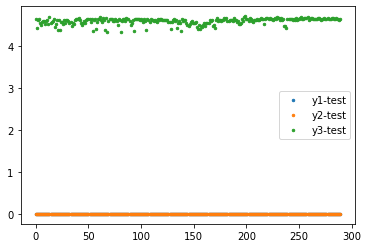

In [7]:
x_ax = range(len(X))
plt.scatter(x_ax, y[:,0],  s=6, label="y1-test")
plt.scatter(x_ax, y[:,1],  s=6, label="y2-test")
plt.scatter(x_ax, y[:,2],  s=6, label="y3-test")
plt.legend()
plt.show()

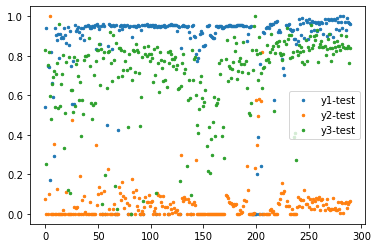

In [8]:
x_ax = range(len(X))
plt.scatter(x_ax, (y[:,0]-min(y[:,0]))/(max(y[:,0])-min(y[:,0])),  s=6, label="y1-test")
plt.scatter(x_ax, (y[:,1]-min(y[:,1]))/(max(y[:,1])-min(y[:,1])),  s=6, label="y2-test")
plt.scatter(x_ax, (y[:,2]-min(y[:,2]))/(max(y[:,2])-min(y[:,2])),  s=6, label="y3-test")
plt.legend()
plt.show()

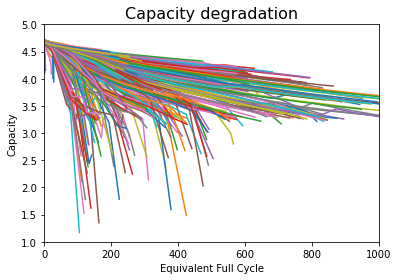

In [11]:
#empirical data
l=1000
d=1
plot_empirical(l,d,all_metrics_df)

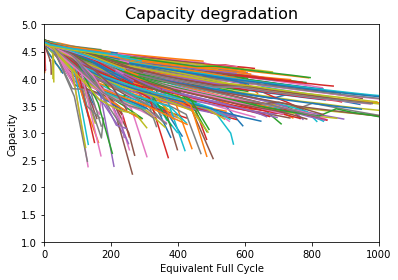

In [12]:
#selected empirical data
plot_empirical_selected(y_selected_key,l,d,all_metrics_df)

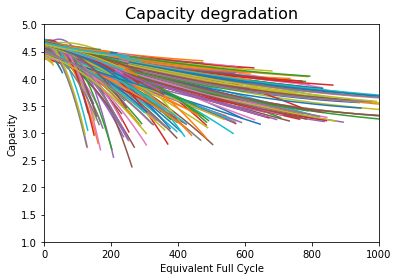

In [14]:
#selected fitting data
plot_curve_pred(y_with_key,y_selected_key,l,d,all_metrics_df,objective)

## 1.4 Correlation Map

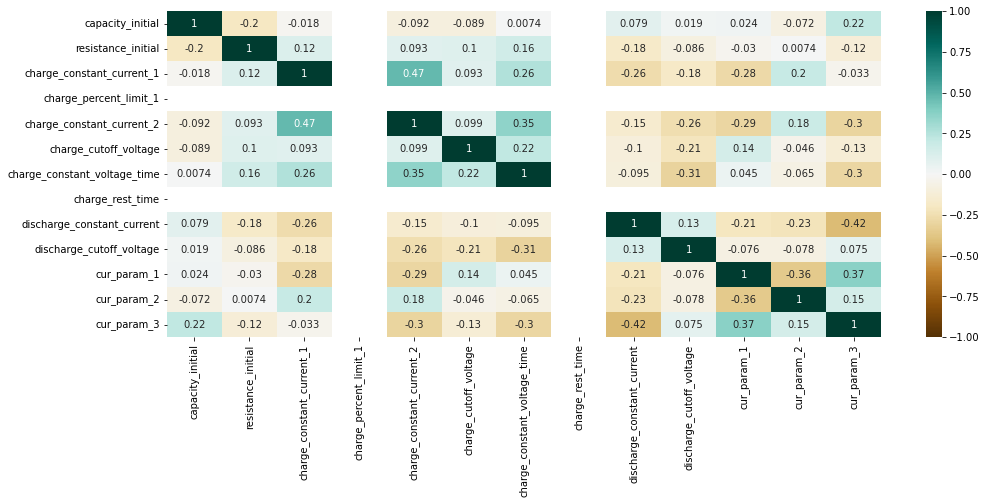

In [15]:
correlation_heatmap(X_Y_merged,testParamDf)

# 2. Train the model

In [17]:
#full gamma
X_train,X_test,y_train_coef,y_test_coef,y_train,y_test,y_train_norm,y_test_norm=data_split(X,y_with_key)
#gamma 1 only
X_train1,X_test1,y_train_coef1,y_test_coef1,y_train1,y_test1,y_train_norm1,y_test_norm1=data_split(X,y_with_key,1)

In [23]:
#mae
model0 = sequential_model(50,32,'mae',X_train,y_train)
model0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 2,281
Trainable params: 2,281
Non-trainable params: 0
_________________________________________________________________


# 3.Prediction

In [24]:
#no validation
lr_model_history_no_val = model0.fit(X_train, y_train_norm, 
                        epochs=100, 
                        verbose=0)

raw_y_pred = model0.predict(X_test)
y_pred = recover(raw_y_pred,y_train)
print("y1 MSE:%.4f" % mean_squared_error(y_test[:,0], y_pred[:,0]))
print("y2 MSE:%.4f" % mean_squared_error(y_test[:,1], y_pred[:,1]))
print("y2 MSE:%.4f" % mean_squared_error(y_test[:,2], y_pred[:,2]))

2021-11-05 20:00:41.525029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-05 20:00:41.528126: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-05 20:00:41.659606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


y1 MSE:0.0000
y2 MSE:0.0000
y2 MSE:0.0031


2021-11-05 20:00:45.410633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


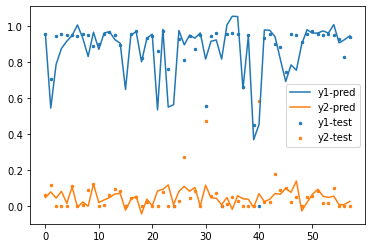

In [25]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test_norm[:,0],  s=6, label="y1-test")
plt.plot(x_ax, raw_y_pred[:,0], label="y1-pred")
plt.scatter(x_ax, y_test_norm[:,1],  s=6, label="y2-test")
plt.plot(x_ax, raw_y_pred[:,1], label="y2-pred")
plt.legend()
plt.show()

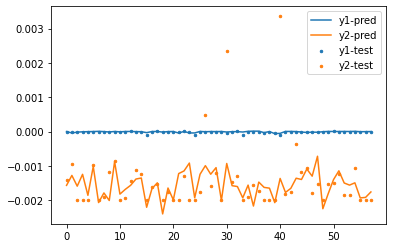

In [26]:
x_ax = range(len(X_test))
plt.scatter(x_ax, y_test[:,0],  s=6, label="y1-test")
plt.plot(x_ax, y_pred[:,0], label="y1-pred")
plt.scatter(x_ax, y_test[:,1],  s=6, label="y2-test")
plt.plot(x_ax, y_pred[:,1], label="y2-pred")
plt.legend()
plt.show()

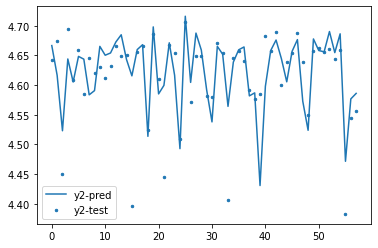

In [27]:
plt.scatter(x_ax, y_test[:,2],  s=6, label="y2-test")
plt.plot(x_ax, y_pred[:,2], label="y2-pred")
plt.legend()
plt.show()

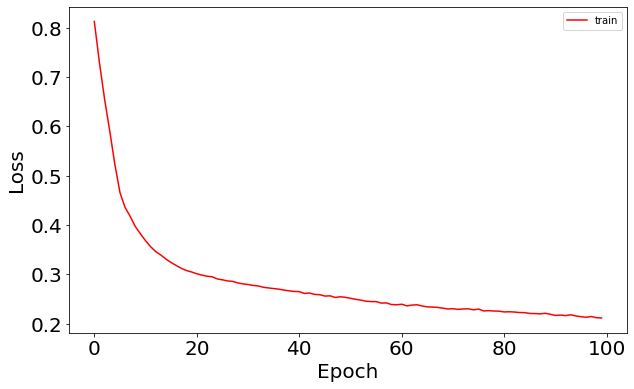

In [28]:
# Plot the loss function with no val
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history_no_val.history['loss']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

## (DONT"t RUN UNLESS NEEDED) What if we add validation part?

2021-11-05 05:12:15.982120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 05:12:16.093382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-05 05:12:20.599891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


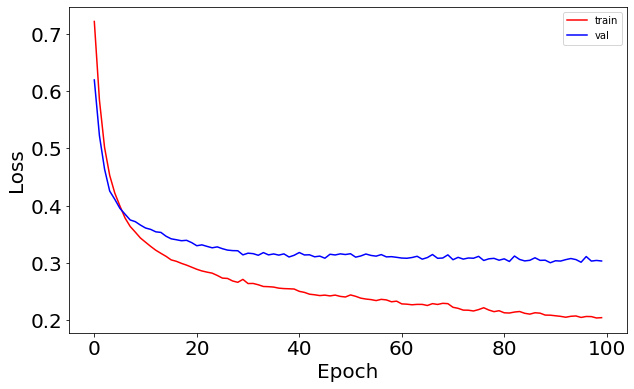

In [68]:
# Plot the loss function
lr_model_history = model0.fit(X_train, y_train_norm, 
                            epochs=100, 
                            verbose=0,
                            validation_data=(X_test, y_test_norm))

y_pred = model0.predict(X_test)*y_train.max(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [29]:
test_key = y_test_coef[:,3]
l = 1200
d = 2

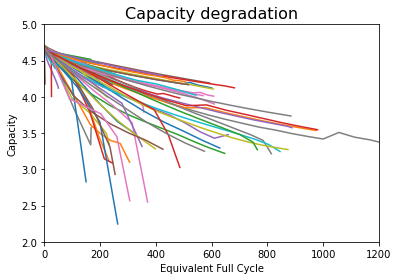

In [32]:
plot_empirical_selected(test_key,l,d,all_metrics_df)

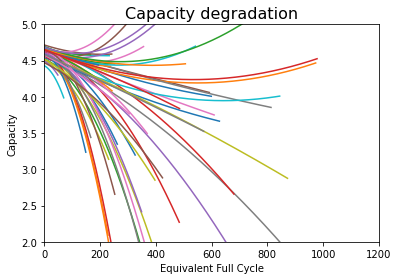

In [34]:
y_with_key_test = np.append(y_pred, test_key.reshape(-1,1), axis = 1)
plot_curve_pred(y_with_key_test,test_key,l,d,all_metrics_df,objective)

# Error Analysis

In [110]:
n=184
select_cell = y_with_key[:,3] == n
print(y_with_key[select_cell,:])
select_cell = y_with_key_test[:,3] == n
print(y_with_key_test[select_cell,:])

[[ 7.07886379e-07 -1.91881827e-03  4.64608047e+00  1.84000000e+02]]
[[ 1.22061542e-06 -2.11443536e-03  4.59102177e+00  1.84000000e+02]]


/var/folders/_w/m21mbpwj00q_0ghj07dwvwj80000gn/T/ipykernel_1388/4097272028.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(key)


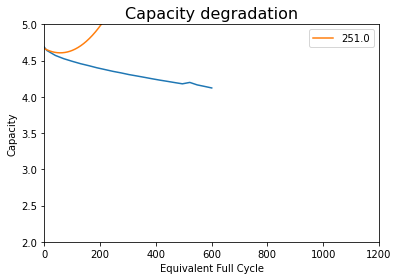

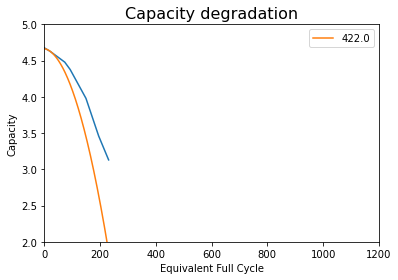

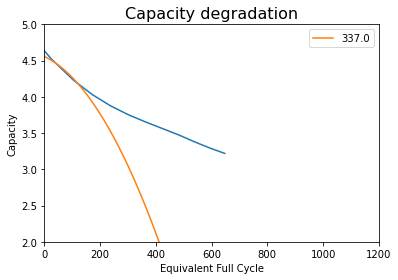

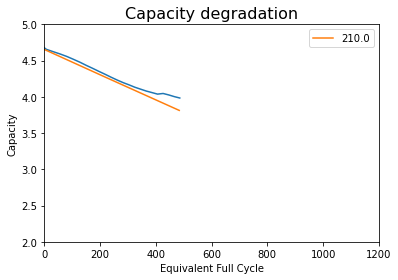

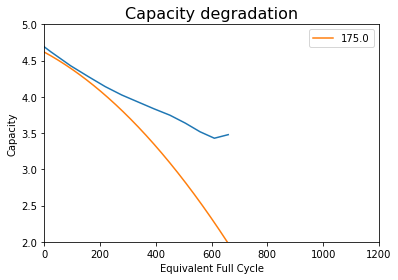

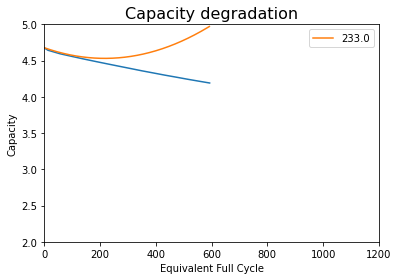

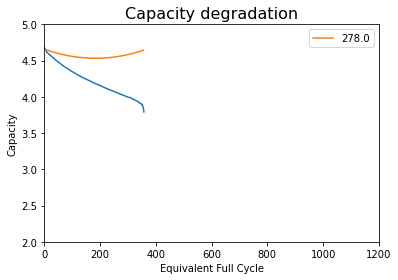

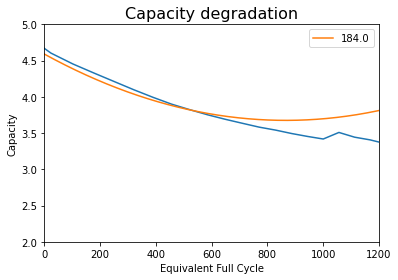

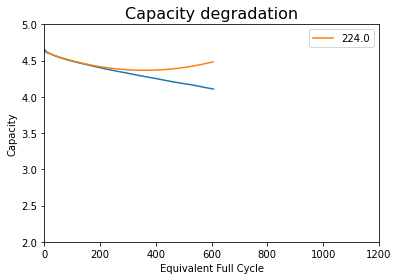

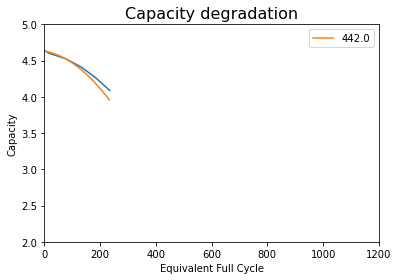

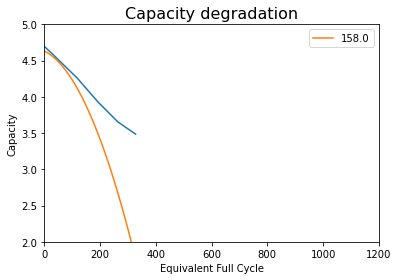

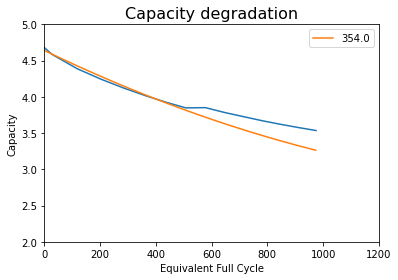

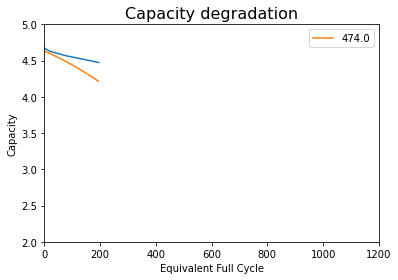

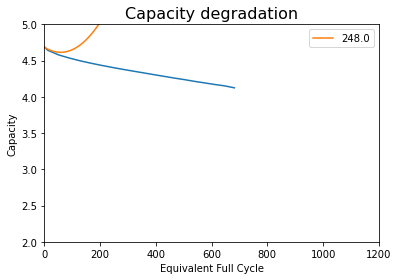

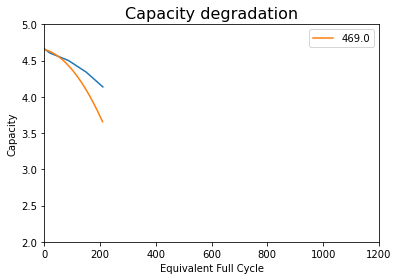

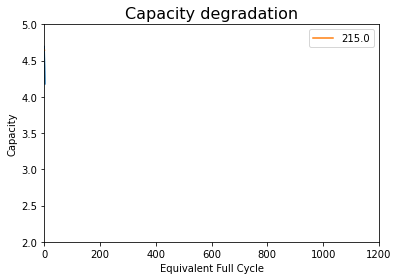

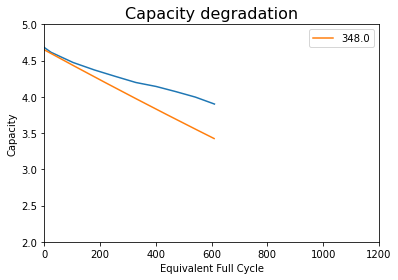

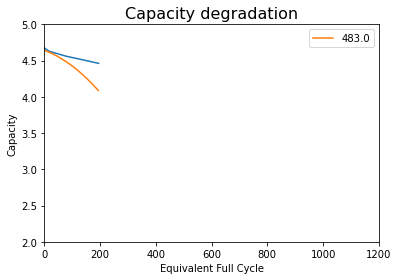

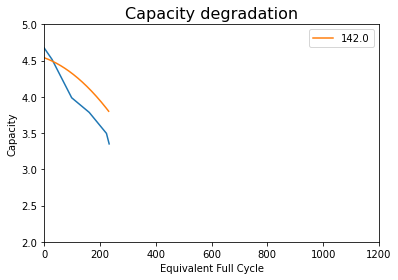

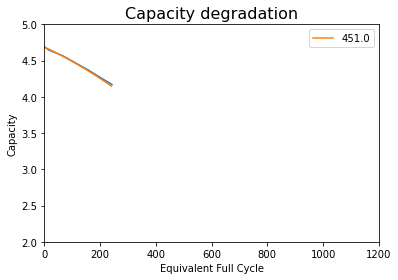

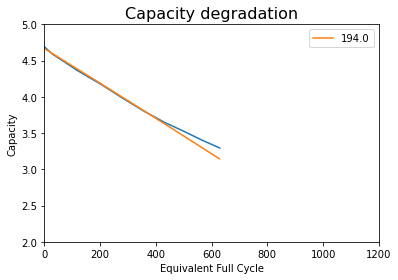

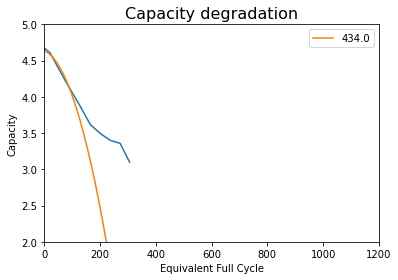

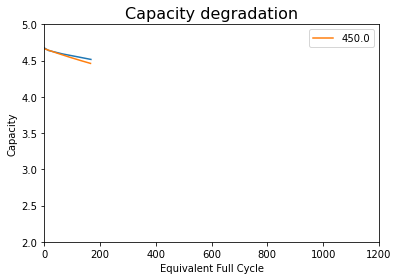

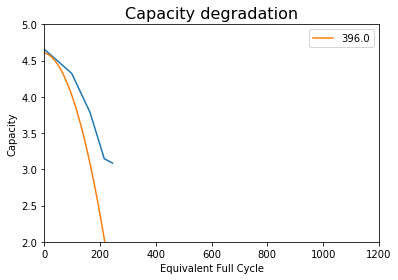

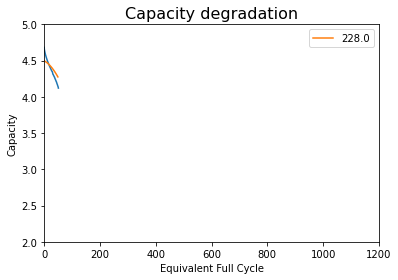

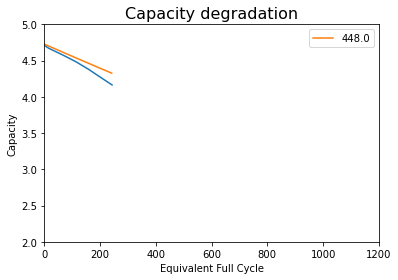

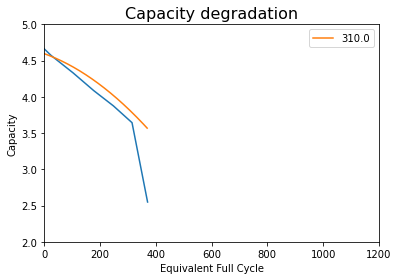

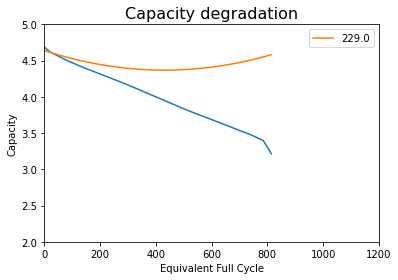

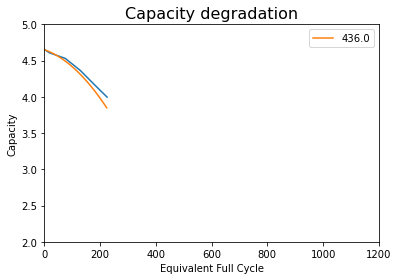

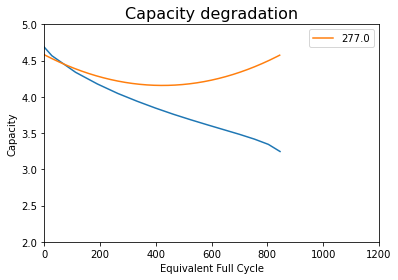

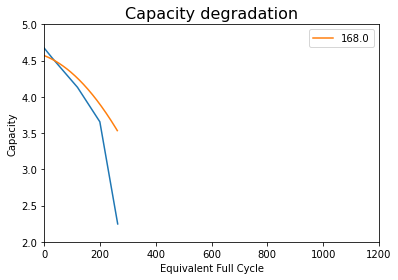

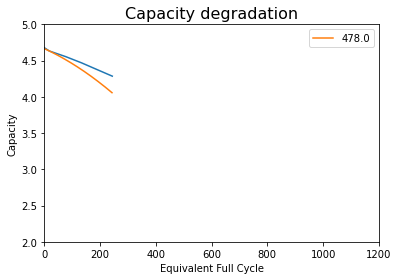

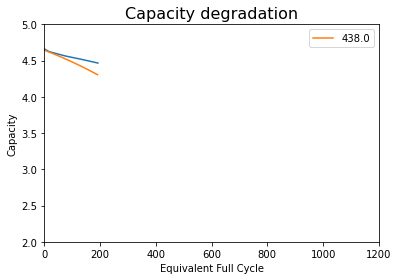

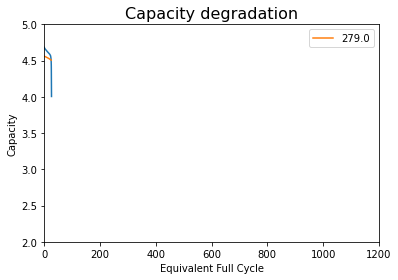

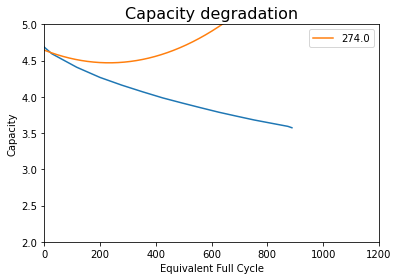

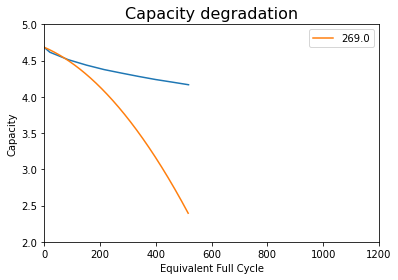

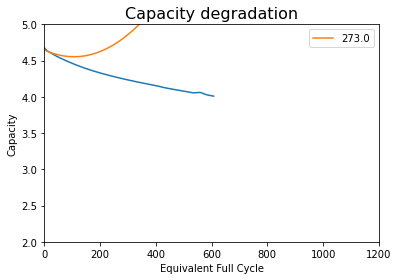

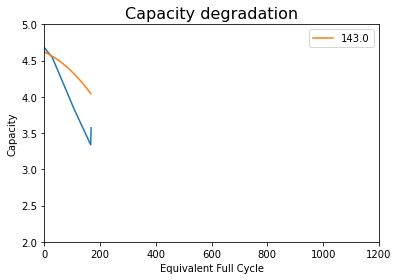

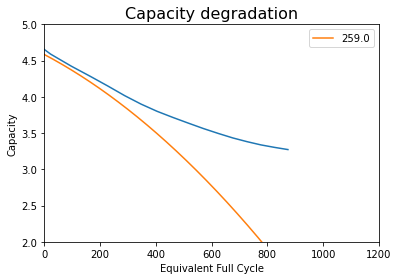

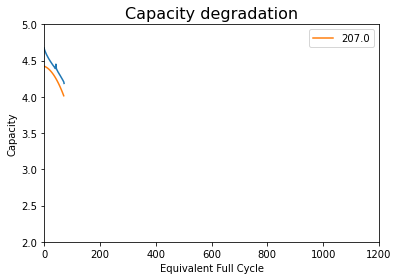

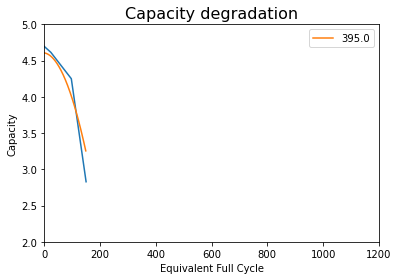

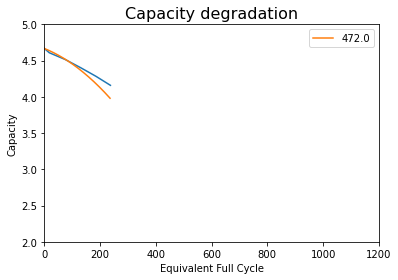

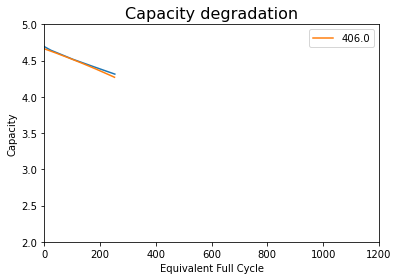

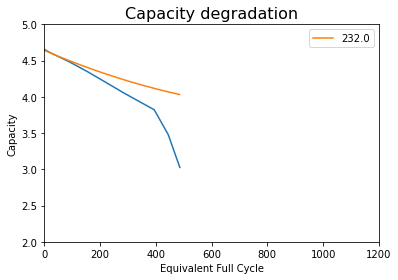

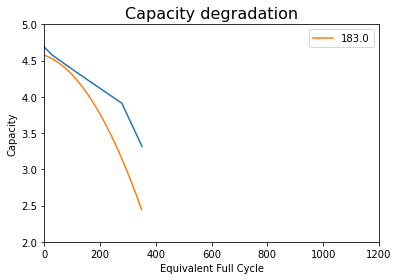

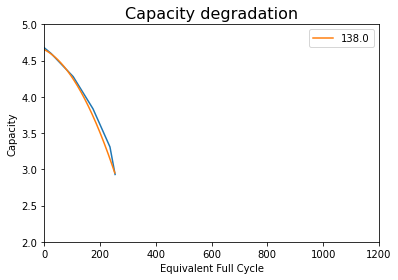

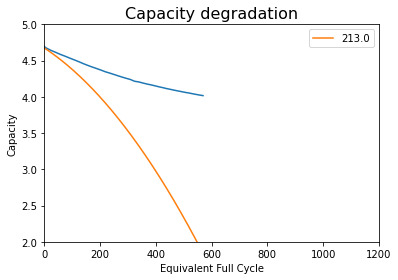

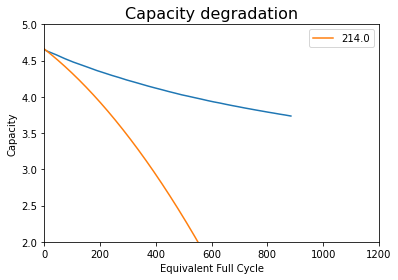

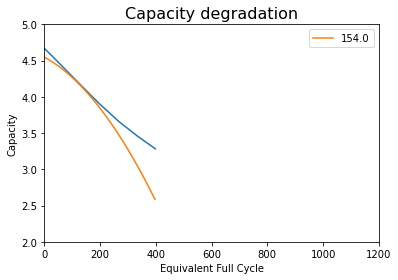

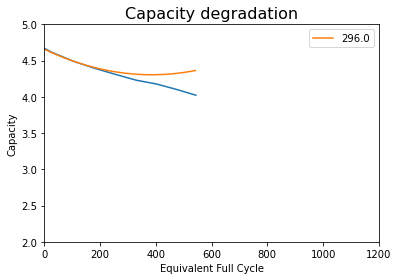

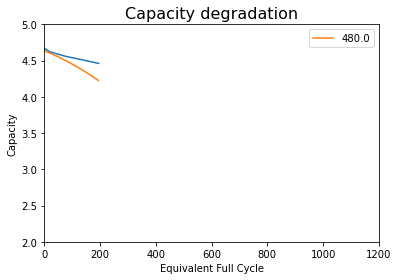

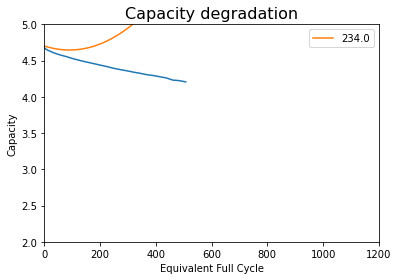

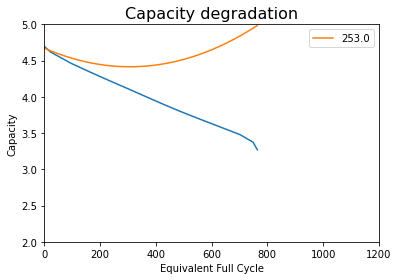

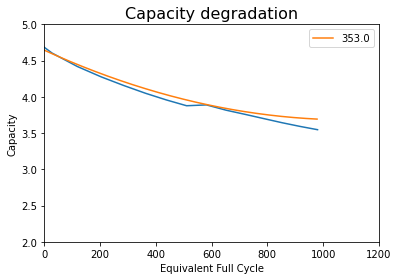

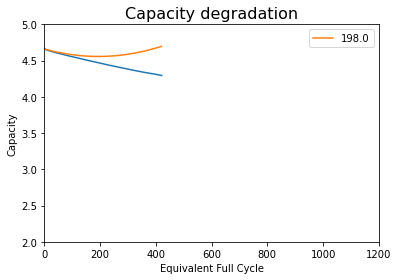

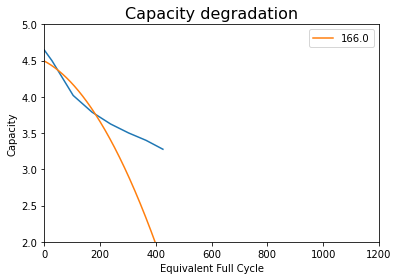

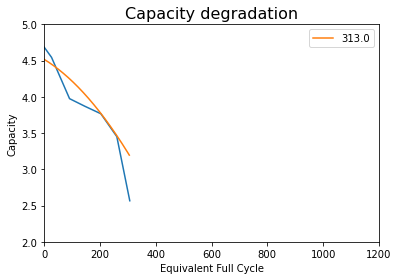

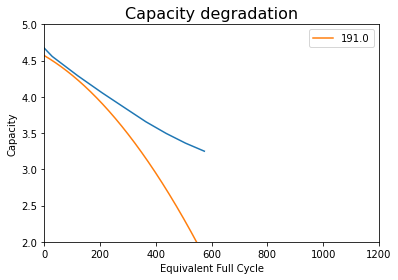

In [107]:
#Predicted Model
for key in test_key:
    inputk = np.array([key])
    plt.figure(key)
    plot_empirical_selected(inputk,l,d)
    plot_curve_pred(y_with_key_test,inputk,l,d)


In [ ]:
#true curve
for key in test_key:
    inputk = np.array([key])
    plt.figure(key)
    plot_empirical_selected(inputk,l,d,all_metrics_df)
    plot_curve_pred(y_with_key,inputk,l,d,all_metrics_df,objective)
